In [1]:
import xarray as xr
from matplotlib import pyplot as plt
plt.style.use('../grl.mplstyle')
import os
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin/'
import numpy as np
import xrft
import glob

### Read data 
Either concatenate along time dimension or at one time.

In [8]:
def open (label):
    tlist = np.array([110,130,150,170])
    filelist = [DIR + label + f'/field{t}.nc' for t in tlist]
    ds = xr.open_mfdataset(filelist, concat_dim='t', combine='nested')
    ds = ds.assign_coords(t=tlist)
    return ds

In [21]:
''' Or read in one time. '''
# Read in
DIR = '/Users/jiarongw/Data/multilayer_data/JPO2024/processed/'

t = 160
ds1 = xr.open_dataset(DIR + 'C4/' + 'field%g.nc' %t)  
ds2 = xr.open_dataset(DIR + 'C4_NL30/' + 'field%g.nc' %t)
ds3 = xr.open_dataset(DIR + 'C4_NL45/' + 'field%g.nc' %t) 

''' Check the depth that is consistently below water. '''
print(ds1.z.isel(zl=-1).min().values)
print(ds2.z.isel(zl=-1).min().values)
print(ds3.z.isel(zl=-1).min().values)

-1.440642386674881
-1.4005476087331772
-1.3899990543723106


Colorbar-like object skipped


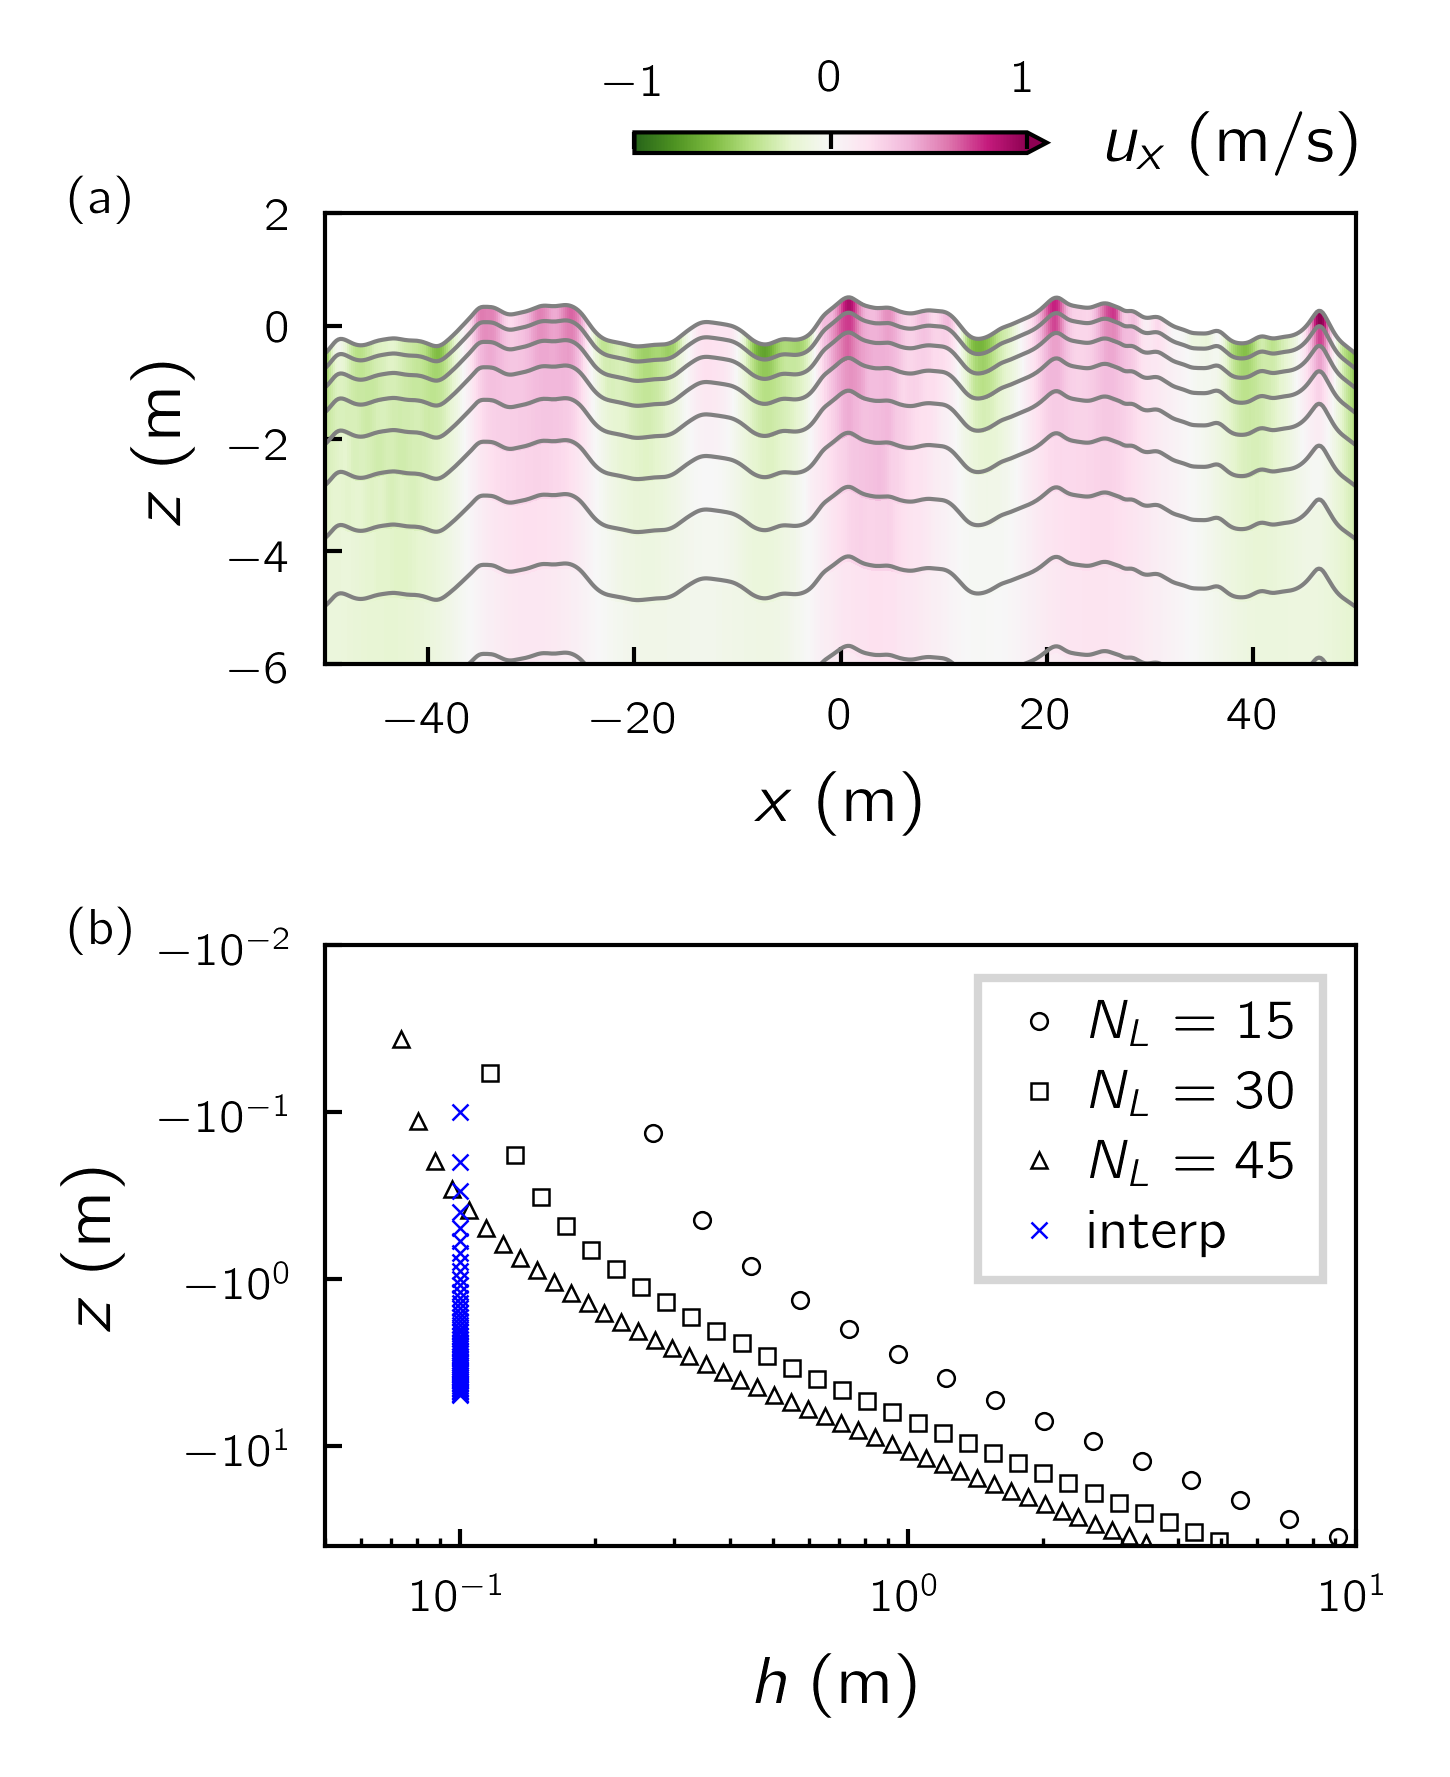

In [22]:
fig, axes = plt.subplots(2, 1, figsize=[2.5,3]); 

# Plot 1
ax = axes[0]
im = ds1.ux.isel(y=512).plot(ax=ax, x='x', y='z', vmax=1., vmin=-1., cmap='PiYG_r',
                        cbar_kwargs={'label':'', 'orientation': 'horizontal', 'pad':0.1,
                                     'shrink': 0.4, 'aspect':20, 'location':'top'})
cbar = im.colorbar
cbar.ax.text(
    1.2, 0.5,                   # Position: (x, y) relative to colorbar (1.02 = slightly to the right, 0.5 = centered vertically)
    "$u_x\: \mathrm{(m/s)}$",            # Label text
    transform=cbar.ax.transAxes, # Use colorbar axis coordinates
    va="center",                 # Vertically center the label
    ha="left",                   # Align text to the left
    rotation=0                   # Keep label horizontal
)
# cbar.ax.set_position([0.1, 0.15, 0.6, 0.03])
ax.set_ylim([-6,2])
ax.set_xlim([-50,50])

for i in range(7,15):
    ds1.z_g.isel(y=512).isel(zl_g=i).plot(ax=ax, x='x', c='gray')
    
eta = ds1.z_g.isel(y=512).isel(zl_g=-1) + ds1.h.isel(y=512).isel(zl=-1) 
eta.plot(ax=ax, x='x', c='gray')   

ax.set_title('') 
ax.set_ylabel('$z \; (\mathrm{m})$')
ax.set_xlabel('$x \; (\mathrm{m})$')

# Plot 2
ax = axes[1]
depth = - 5 # depth choice
znew = np.arange(-5,0.1,0.1)

z1 = ds1.z.mean(dim=['x','y','t'])
z2 = ds2.z.mean(dim=['x','y','t'])
z3 = ds3.z.mean(dim=['x','y','t'])

ax.plot(ds1.h.mean(dim=['x','y','t']), z1, 'o', c='k', label='$N_L=15$')
ax.plot(ds2.h.mean(dim=['x','y','t']), z2, 's', c='k', label='$N_L=30$')
ax.plot(ds3.h.mean(dim=['x','y','t']), z3, '^', c='k', label='$N_L=45$')
ax.plot(znew/znew*0.1, znew, 'x', label='interp')
ax.set_ylim([-40,-0.01]); ax.set_xlim([0.05,10])
ax.set_ylabel('$z \;\mathrm{ (m)}$')
ax.set_yticks([-10,-1,-0.1])
ax.set_xlabel('$h \;\mathrm{ (m)}$')
ax.set_yscale('symlog', linthresh=1e-2)
ax.set_xscale('log')
ax.legend()

ax.set_title('')
from mlpython.plot import set_letters
set_letters(x=-0.25, y=1, fontsize=6)

plt.tight_layout()
fig.savefig('plots/layers_coord.pdf', bbox_inches='tight')

### Interpolate onto regular (evenly spaced) z grid 
Cannot directly use the xarray interp method because z is not an independent dimension. Instead we call the scipy interp1d function iteratively.

In [2]:
from mlpython.utils import interpz, compute_diss
DIR = '/Users/jiarongw/Data/multilayer_data/JPO2024/processed/'
t = 160
ds = xr.open_dataset(DIR + 'C4_NL30/' + 'field%g.nc' %t)  
ds = compute_diss(ds).compute()
ds

<xarray.Dataset>
Dimensions:  (t: 1, zl: 30, x: 1024, y: 1024, x_g: 1024, y_g: 1024, zl_g: 30)
Coordinates:
  * x        (x) float64 -99.9 -99.71 -99.51 -99.32 ... 99.32 99.51 99.71 99.9
  * x_g      (x_g) float64 -100.0 -99.8 -99.61 -99.41 ... 99.22 99.41 99.61 99.8
  * y        (y) float64 -99.9 -99.71 -99.51 -99.32 ... 99.32 99.51 99.71 99.9
  * y_g      (y_g) float64 -100.0 -99.8 -99.61 -99.41 ... 99.22 99.41 99.61 99.8
  * zl       (zl) int64 0 1 2 3 4 5 6 7 8 9 10 ... 20 21 22 23 24 25 26 27 28 29
  * zl_g     (zl_g) float64 -0.5 0.5 1.5 2.5 3.5 ... 24.5 25.5 26.5 27.5 28.5
    z        (t, zl, x, y) float64 -37.54 -37.54 -37.54 ... -0.247 -0.2635
    z_g      (t, zl_g, x, y) float64 -40.0 -40.0 -40.0 ... -0.305 -0.3214
Dimensions without coordinates: t
Data variables: (12/18)
    h        (t, zl, x, y) float32 4.927 4.925 4.922 ... 0.1162 0.1161 0.1159
    ux       (t, zl, x, y) float32 0.004677 0.004721 ... -0.2383 -0.2633
    uy       (t, zl, x, y) float32 -0.00228 -0.002268 ... -0.6577 -0.6524
    uz       (t, zl, x, y) float32 -0.002149 -0.00216 ... -0.7982 -0.8693
    dudz     (t, zl, x, y) float64 -0.0001721 -0.0001738 ... -0.02205 -0.005731
    dudy     (t, zl, x, y) float64 0.0002206 0.0002206 ... -0.1142 -0.1424
    ...       ...
    dwdx     (t, zl, x, y) float64 0.0001068 0.0001081 ... 0.1022 0.1027
    epsilon  (t, zl, x, y) float64 1.664e-06 1.677e-06 ... 0.6586 0.8245
    omegaxp  (t, zl, x, y) float64 -0.0001387 -0.0001374 ... -0.002914 -0.07622
    omegayp  (t, zl, x, y) float64 -0.000279 -0.0002818 ... -0.1243 -0.1085
    omegazp  (t, zl, x, y) float64 4.317e-07 8.026e-08 ... 0.01172 0.01133
    vort2    (t, zl, x, y) float64 9.707e-08 9.83e-08 ... 0.01559 0.0177
Attributes:
    sourcepath:  /projects/DEIKE/jiarongw/multilayer/revision/field_new_200m_...
    L:           200
    P:           0.02
    Re:          40000
    LEVEL:       10
    NL:          30
    rand:        2
    Htheta:      0.503
    H:           40.0
    label:       C4_NL30

In [12]:
znew = np.arange(-5,0.1,0.1)

ux_interp = interpz(znew, ds.z, ds['ux'], fill_value=np.nan).mean(dim=['x','y']).compute()
uy_interp = interpz(znew, ds.z, ds['uy'], fill_value=np.nan).mean(dim=['x','y']).compute()
vort2_interp = interpz(znew, ds.z, ds['vort2'], fill_value=np.nan).mean(dim=['x','y']).compute()
epsilon_interp = interpz(znew, ds.z, ds['epsilon'], fill_value=np.nan).mean(dim=['x','y']).compute()

ux_interp_zero = interpz(znew, ds.z, ds['ux'], fill_value=0).mean(dim=['x','y']).compute()
uy_interp_zero = interpz(znew, ds.z, ds['uy'], fill_value=0).mean(dim=['x','y']).compute()
vort2_interp_zero = interpz(znew, ds.z, ds['vort2'], fill_value=0).mean(dim=['x','y']).compute()
epsilon_interp_zero = interpz(znew, ds.z, ds['epsilon'], fill_value=0).mean(dim=['x','y']).compute()

/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/utils.py:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds, fill_value: xr.apply_ufunc (
/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/utils.py:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds, fill_value: xr.apply_ufunc (
/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/utils.py:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds, fill_value: xr.apply_ufunc (
/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/utils.py:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` 

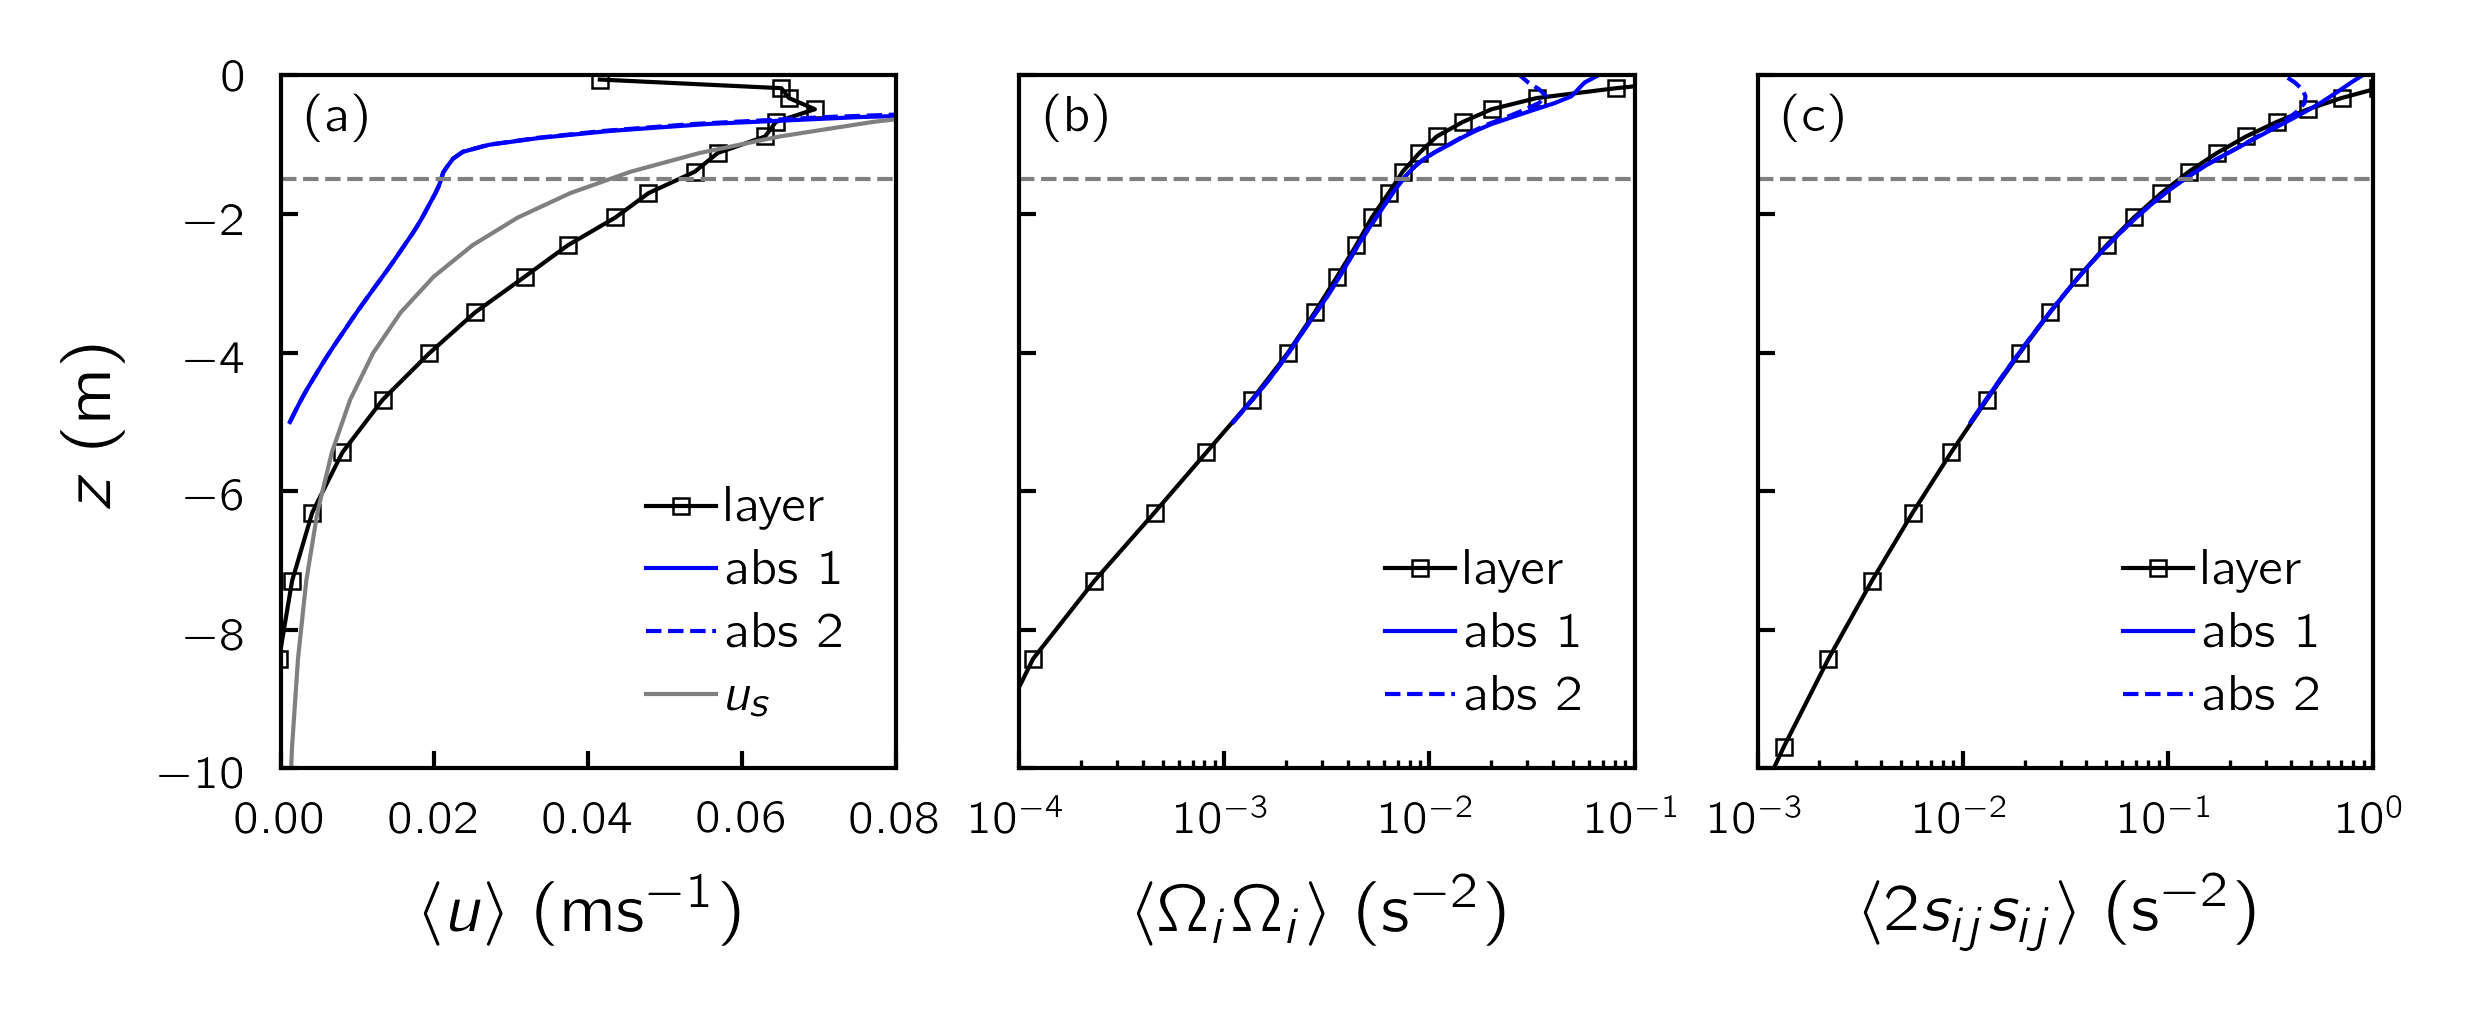

In [19]:
fig, axes = plt.subplots(1, 3, figsize=[4.5,1.5], sharey=True)
from mlpython.plot import set_letters

######## Velocity ########
ax = axes[0]
l1 = ax.plot(ds.ux.mean(['x','y']).values.flatten(), ds.z.mean(['x','y']).values.flatten(), 
             '-s', c='k', label='layer')
l2 = ax.plot(ux_interp.values.flatten(), znew, '-', c='b', label='abs 1')
l2 = ax.plot(ux_interp_zero.values.flatten(), znew, '--', c='b', label='abs 2')


# Plot the corresponding Stokes drift magnitude
from mlpython.utils import spectrum_us
filename = '/Users/jiarongw/Data/multilayer_data/JFM2023/compilation/dissipation_C4_rand4.nc'
diss = xr.open_dataset(filename, engine='h5netcdf')
zmean = ds.z.mean(['x','y']).values.flatten()
us = spectrum_us(diss.kbins, diss.F[-1], zmean) # The last time step in the dissipation file (t=160-180)
ls = axes[0].plot(us, zmean, c='gray', label='$u_s$')

####### Omega #######
ax = axes[1]
l1 = ax.plot(ds.vort2.mean(['x','y']).values.flatten(), ds.z.mean(['x','y']).values.flatten(),
             '-s', c='k', label='layer')
l2 = ax.plot(vort2_interp.values.flatten(), znew, '-', c='b', label='abs 1')
l3 = ax.plot(vort2_interp_zero.values.flatten(), znew, '--', c='b', label='abs 2')

####### Strain rate ######
ax = axes[2]
l1 = ax.plot(ds.epsilon.mean(['x','y']).values.flatten(), ds.z.mean(['x','y']).values.flatten(), 
             '-s', c='k', label='layer')
l2 = ax.plot(epsilon_interp.values.flatten(), znew, '-', c='b', label='abs 1')
l3 = ax.plot(epsilon_interp_zero.values.flatten(), znew, '--', c='b', label='abs 2')

for ax in axes:
    ax.axhline(y=-1.5, ls='--', c='gray')
    ax.set_ylim([-10,0])
    ax.legend(frameon=False, loc='lower right', fontsize=6)  # Remove legend box


axes[0].set_xlim([0,0.08])
axes[0].set_xlabel(r'$\langle u \rangle \; \mathrm{(ms^{-1})}$')
axes[0].set_ylabel(r'$z\; \mathrm{(m)}$')

axes[1].set_xlim([0.0001,0.1])
axes[1].set_xscale('log')
axes[1].set_xlabel(r'$\langle \Omega_i \Omega_i \rangle \; \mathrm{(s^{-2})}$')

axes[2].set_xlim([0.001,1])
axes[2].set_xscale('log')
axes[2].set_xlabel(r'$\langle 2s_{ij}s_{ij} \rangle \; \mathrm{(s^{-2})}$')

set_letters(x=0.04, y=0.92, fontsize=6)
plt.savefig('plots/aver_layer_interp_new.pdf', bbox_inches='tight')
plt.show()

### Test whethet it makes a difference by filling NaN (ignoring air side) or filling with zero (diluting the averaging)

In [ ]:
znew = np.arange(-1.5,0.5,0.1)

ux_interp = interpz(znew, ds.z, ds['ux'], fill_value=np.nan).mean(dim=['x','y']).compute()
uy_interp = interpz(znew, ds.z, ds['uy'], fill_value=np.nan).mean(dim=['x','y']).compute()
vort2_interp = interpz(znew, ds.z, ds['vort2'], fill_value=np.nan).mean(dim=['x','y']).compute()
epsilon_interp = interpz(znew, ds.z, ds['epsilon'], fill_value=np.nan).mean(dim=['x','y']).compute()

ux_interp_zero = interpz(znew, ds.z, ds['ux'], fill_value=0).mean(dim=['x','y']).compute()
uy_interp_zero = interpz(znew, ds.z, ds['uy'], fill_value=0).mean(dim=['x','y']).compute()
vort2_interp_zero = interpz(znew, ds.z, ds['vort2'], fill_value=0).mean(dim=['x','y']).compute()
epsilon_interp_zero = interpz(znew, ds.z, ds['epsilon'], fill_value=0).mean(dim=['x','y']).compute()

/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/utils.py:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds, fill_value: xr.apply_ufunc (
/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/utils.py:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds, fill_value: xr.apply_ufunc (
/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/utils.py:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds, fill_value: xr.apply_ufunc (
/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/utils.py:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` 

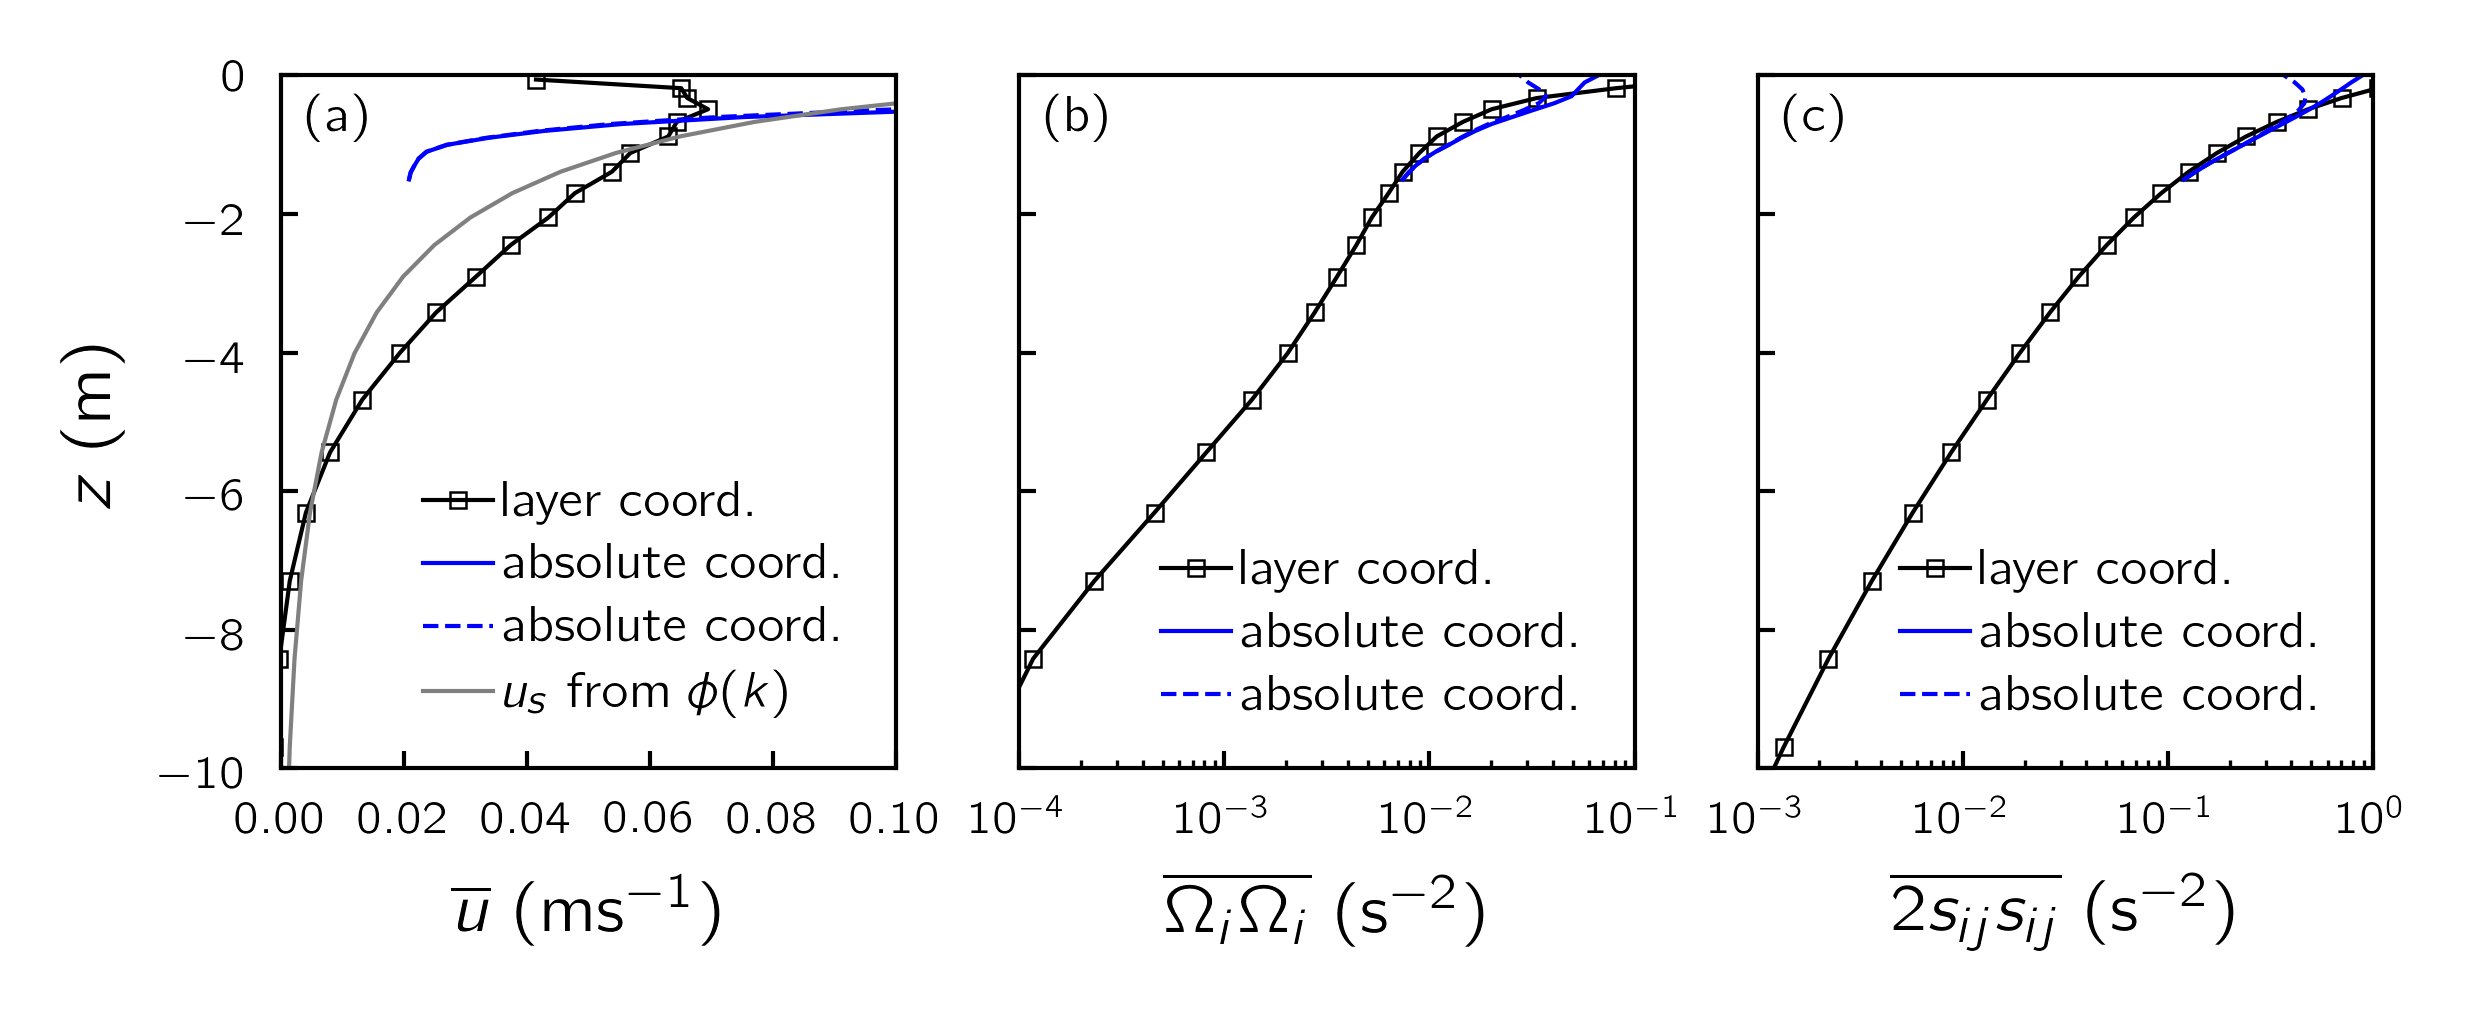

In [11]:
fig, axes = plt.subplots(1, 3, figsize=[4.5,1.5], sharey=True)
from mlpython.plot import set_letters

######## Velocity ########
ax = axes[0]
l1 = ax.plot(ds.ux.mean(['x','y']).values.flatten(), ds.z.mean(['x','y']).values.flatten(), 
             '-s', c='k', label='layer coord.')
l2 = ax.plot(ux_interp.values.flatten(), znew, '-', c='b', label='absolute coord.')
l2 = ax.plot(ux_interp_zero.values.flatten(), znew, '--', c='b', label='absolute coord.')

# Plot the corresponding Stokes drift magnitude
from mlpython.utils import spectrum_us
filename = '/Users/jiarongw/Data/multilayer_data/JFM2023/compilation/dissipation_C4_rand4.nc'
diss = xr.open_dataset(filename, engine='h5netcdf')
zmean = ds.z.mean(['x','y']).values.flatten()
us = spectrum_us(diss.kbins, diss.F[-1], zmean) # The last time step in the dissipation file (t=160-180)
ls = axes[0].plot(us, zmean, c='gray', label='$u_s \; \mathrm{from}  \; \phi(k)$')

####### Omega #######
ax = axes[1]
l1 = ax.plot(ds.vort2.mean(['x','y']).values.flatten(), ds.z.mean(['x','y']).values.flatten(),
             '-s', c='k', label='layer coord.')
l2 = ax.plot(vort2_interp.values.flatten(), znew, '-', c='b', label='absolute coord.')
l2 = ax.plot(vort2_interp_zero.values.flatten(), znew, '--', c='b', label='absolute coord.')

####### Strain rate ######
ax = axes[2]
l1 = ax.plot(ds.epsilon.mean(['x','y']).values.flatten(), ds.z.mean(['x','y']).values.flatten(), 
             '-s', c='k', label='layer coord.')
l2 = ax.plot(epsilon_interp.values.flatten(), znew, 
             '-', c='b', label='absolute coord.')
l2 = ax.plot(epsilon_interp_zero.values.flatten(), znew, 
             '--', c='b', label='absolute coord.')

for ax in axes:
    ax.set_ylim([-10,0])
    ax.legend(frameon=False, loc='lower right', fontsize=6)  # Remove legend box


axes[0].set_xlim([0,0.1])
axes[0].set_xticks([0,0.02,0.04,0.06,0.08,0.1])
axes[0].set_xlabel(r'$\overline{u} \; \mathrm{(ms^{-1})}$')
axes[0].set_ylabel(r'$z\; \mathrm{(m)}$')

axes[1].set_xlim([0.0001,0.1])
axes[1].set_xscale('log')
axes[1].set_xlabel(r'$\overline{\Omega_i \Omega_i}\; \mathrm{(s^{-2})}$')

axes[2].set_xlim([0.001,1])
axes[2].set_xscale('log')
axes[2].set_xlabel(r'$\overline{2s_{ij}s_{ij}}\; \mathrm{(s^{-2})}$')

set_letters(x=0.04, y=0.92, fontsize=6)
# plt.savefig('plots/aver_layer_interp.pdf', bbox_inches='tight')
plt.show()

#### Old plots: horizontal velocity

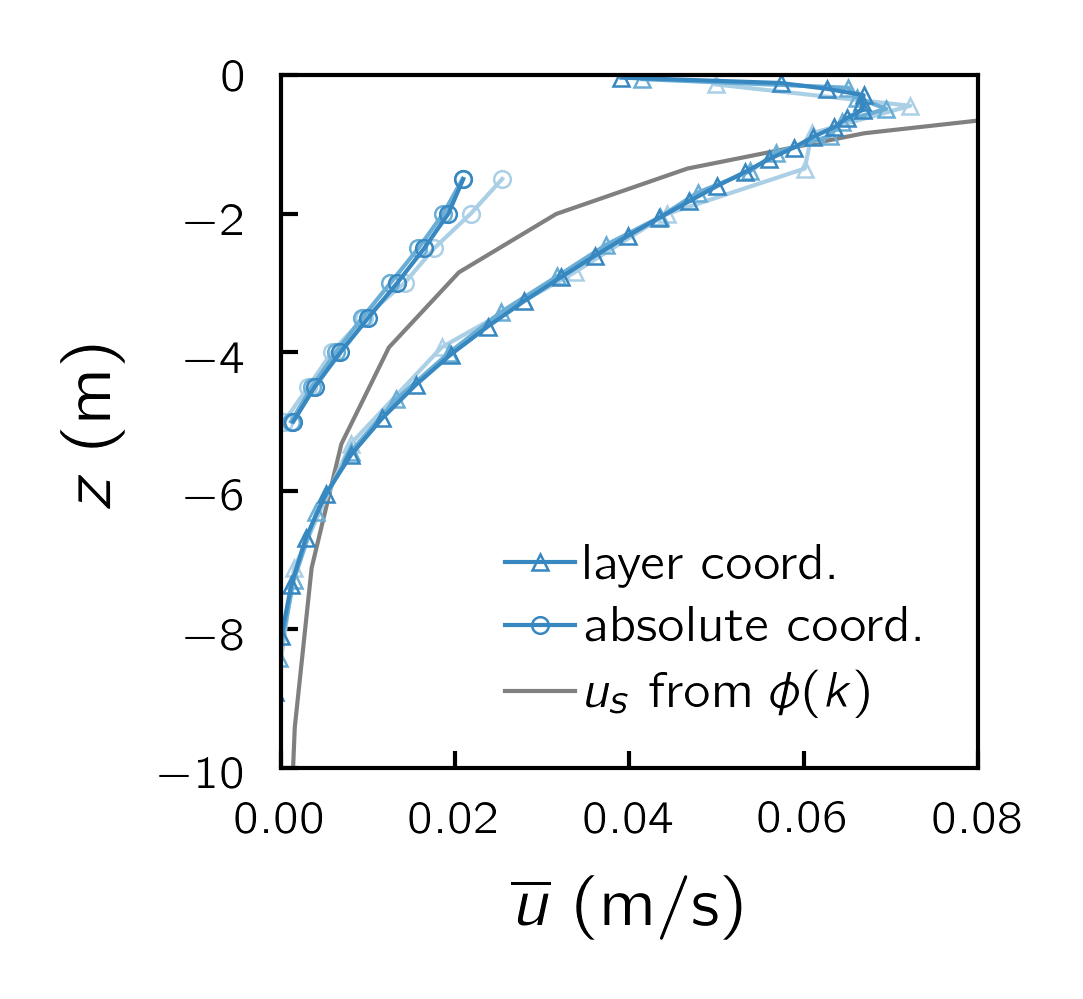

In [8]:
fig = plt.figure(figsize=[1.5,1.5]); ax = plt.gca()

t = 160
znew = np.arange(-5,-1.,0.5)

# lss = ['-o', '-^', '-s']
colors = ['tab:brown','tab:pink','tab:olive']

# var_originals = []
# var_interps = []
# for i, ds in enumerate((ds1,ds2,ds3)):
#     # layered coordinate
#     var = ds.ux
#     var_originals.append(var.compute())
#     # interpolate to absolute coordinate 
#     var_interp = interpz(znew, ds.z.sel(t=t), var.sel(t=t))
#     var_interps.append(var_interp.compute())

# Plot the corresponding Stokes drift magnitude
from utils import spectrum_us
filename = '../../multilayer/JFM2023/compilation/' + 'dissipation_' + 'C4' + '.nc'
diss = xr.open_dataset(filename, engine='h5netcdf')
zmean = ds1.z.sel(t=t).mean(['x','y'])
us = spectrum_us(diss.kbins, diss.F[-1], zmean.values) # The last time step in the dissipation file (t=160-180)
ls, = ax.plot(us, zmean, c='gray')

for i, ds in enumerate((ds1,ds2,ds3)):
    zmean = ds.z.sel(t=t).mean(['x','y']); mean = var_originals[i].sel(t=t).mean(['x','y'])
    l1, = ax.plot(mean, zmean, '-^', c=plt.get_cmap('Blues')((i+2)/6))
    l2, = ax.plot(var_interps[i].mean(['x','y']), znew, '-o', c=plt.get_cmap('Blues')((i+2)/6))
    
        
ax.set_ylim([-10,0])
ax.set_xlim([0,0.08])
# ax.set_xscale('log')
ax.set_xlabel(r'$\overline{u} \; \mathrm{(m/s)}$')
ax.set_ylabel(r'$z\; \mathrm{(m)}$')
# ax.set_ylabel(r'$\overline{z_l} \; \mathrm{or} \; z$', labelpad=0)
plt.legend([l1, l2, ls], ['layer coord.', 'absolute coord.', '$u_s \; \mathrm{from}  \; \phi(k)$'], 
           frameon=False, loc='lower right', fontsize=6)  # Remove legend box
plt.savefig('../figures/multilayer-diss/uaver_new.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Three vorticity components

/var/folders/3x/6pxbtcd51_3f99c16lp56vbr0000gn/T/ipykernel_24636/3287885186.py:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds: xr.apply_ufunc (
/var/folders/3x/6pxbtcd51_3f99c16lp56vbr0000gn/T/ipykernel_24636/3287885186.py:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds: xr.apply_ufunc (
/var/folders/3x/6pxbtcd51_3f99c16lp56vbr0000gn/T/ipykernel_24636/3287885186.py:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds: xr.apply_ufunc (


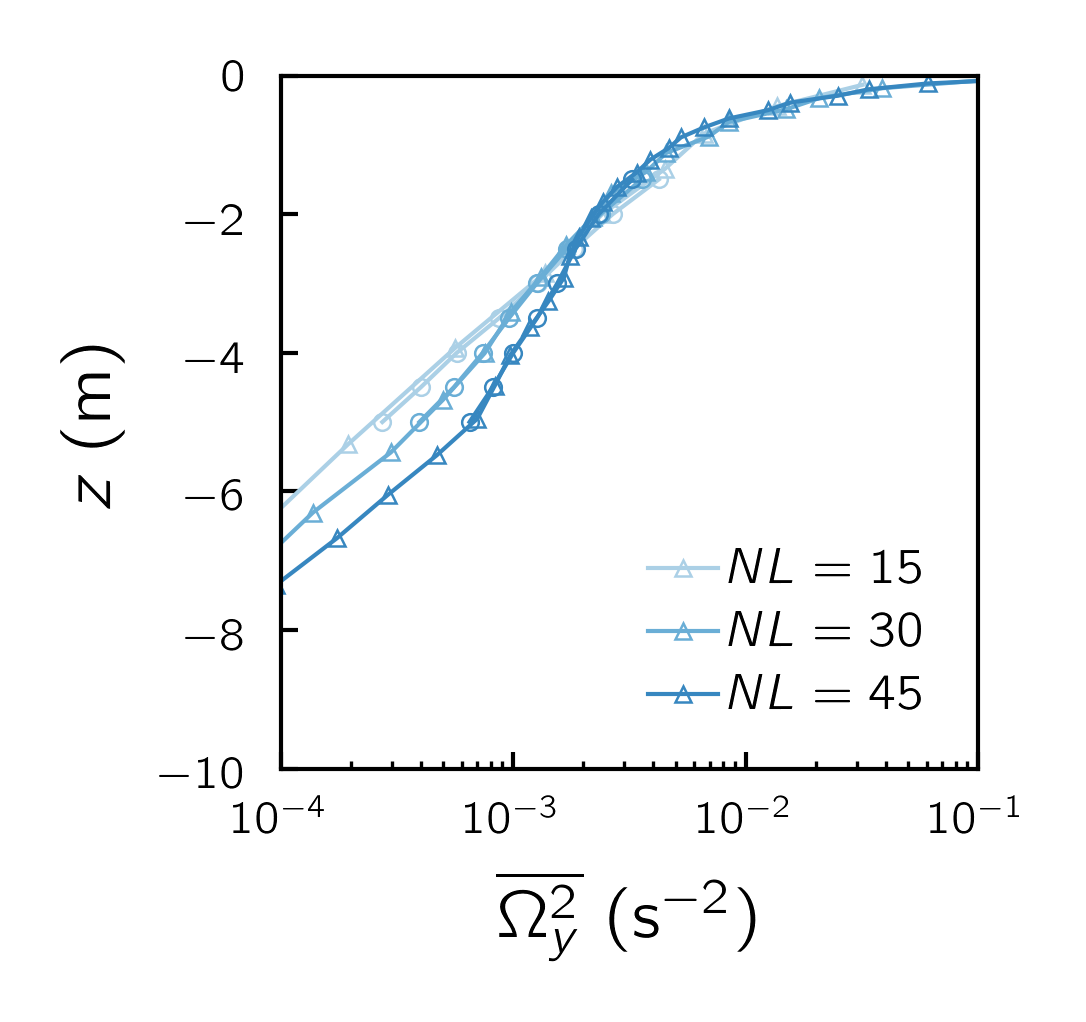

In [164]:
''' First square and then interpolate. '''
fig = plt.figure(figsize=[1.5,1.5]); ax = plt.gca()

t = 160
znew = np.arange(-5,-1.,0.5)

var_originals = []
var_interps = []
for i, ds in enumerate((ds1,ds2,ds3)):
    var = ds.omegay**2
    # layered coordinate
    var_originals.append(var.compute())
    # interpolate to absolute coordinate 
    var_interp = interpz(znew, ds.z.sel(t=t), var.sel(t=t))
    var_interps.append(var_interp.compute())

for i, ds in enumerate((ds1,ds2,ds3)):
    zmean = ds.z.sel(t=t).mean(['x','y']); mean = var_originals[i].sel(t=t).mean(['x','y'])
    ax.plot(mean, zmean, '-^', c=plt.get_cmap('Blues')((i+2)/6), label='$NL=%g$' %ds.sizes['zl'])
    ax.plot(var_interps[i].mean(['x','y']), znew, '-o', c=plt.get_cmap('Blues')((i+2)/6))
            
ax.set_ylim([-10,0])
ax.set_xlim([0.0001,0.1])
ax.set_xscale('log')
ax.set_xlabel(r'$\overline{\Omega_y^2}\; \mathrm{(s^{-2})}$')
ax.set_ylabel(r'$z\; \mathrm{(m)}$')
ax.legend(fontsize=6, frameon=False, loc='lower right')
plt.show()

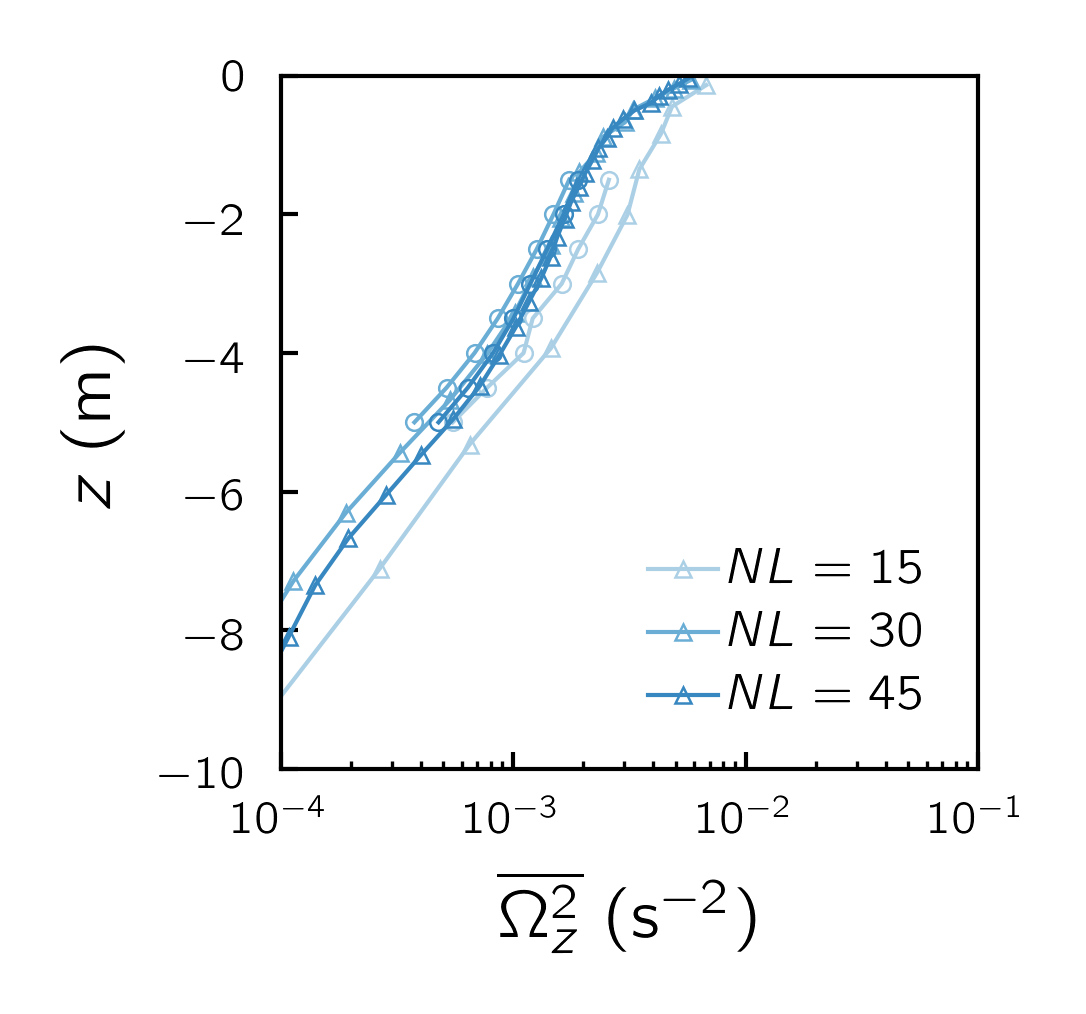

In [17]:
''' First interpolate and then square. '''

fig = plt.figure(figsize=[1.5,1.5]); ax = plt.gca()

t = 160
znew = np.arange(-5,-1.,0.5)

# var_originals = []
# var_interps = []
# for i, ds in enumerate((ds1,ds2,ds3)):
#     var = ds.omegaz
#     # layered coordinate
#     var_originals.append(var.compute())
#     # interpolate to absolute coordinate 
#     var_interp = interpz(znew, ds.z.sel(t=t), var.sel(t=t))
#     var_interps.append(var_interp.compute())

for i, ds in enumerate((ds1,ds2,ds3)):
    zmean = ds.z.sel(t=t).mean(['x','y'])
    omega2 = (var_originals[i].sel(t=t))**2
    ax.plot(omega2.mean(['x','y']), zmean, '-^', c=plt.get_cmap('Blues')((i+2)/6), label='$NL=%g$' %ds.sizes['zl'])
    omega2_interp = (var_interps[i])**2
    ax.plot(omega2_interp.mean(['x','y']), znew, '-o', c=plt.get_cmap('Blues')((i+2)/6))
            
ax.set_ylim([-10,0])
ax.set_xlim([0.0001,0.1])
ax.set_xscale('log')
ax.set_xlabel(r'$\overline{\Omega_z^2}\; \mathrm{(s^{-2})}$')
ax.set_ylabel(r'$z\; \mathrm{(m)}$')
ax.legend(fontsize=6, frameon=False, loc='lower right')
plt.show()

#### Vorticity magnitude squared

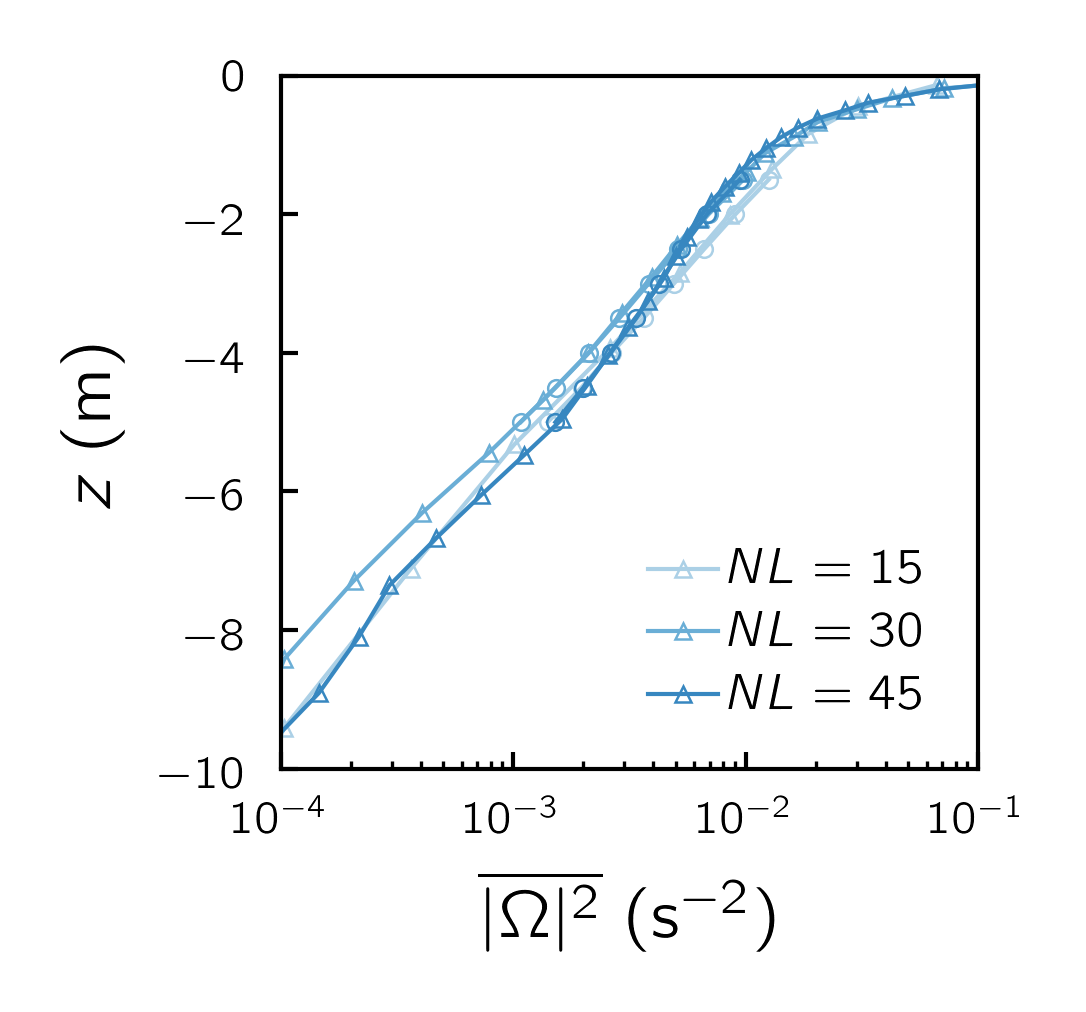

In [148]:
fig = plt.figure(figsize=[1.5,1.5]); ax = plt.gca()

t = 160
znew = np.arange(-5,-1.,0.5)

# var_originals = []
# var_interps = []
# for i, ds in enumerate((ds1,ds2,ds3)):
#     # layered coordinate
#     var = ds.omegax**2 + ds.omegay**2 + ds.omegaz**2
#     var_originals.append(var.compute())
#     # interpolate to absolute coordinate 
#     var_interp = interpz(znew, ds.z.sel(t=t), var.sel(t=t))
#     var_interps.append(var_interp.compute())

for i, ds in enumerate((ds1,ds2,ds3)):
    zmean = ds.z.sel(t=t).mean(['x','y']); mean = var_originals[i].sel(t=t).mean(['x','y'])
    ax.plot(mean, zmean, '-^', c=plt.get_cmap('Blues')((i+2)/6), label='$NL=%g$' %ds.sizes['zl'])
    ax.plot(var_interps[i].mean(['x','y']), znew, '-o', c=plt.get_cmap('Blues')((i+2)/6))
            
ax.set_ylim([-10,0])
ax.set_xlim([0.0001,0.1])
ax.set_xscale('log')
ax.set_xlabel(r'$\overline{|\mathbf{\Omega}|^2}\; \mathrm{(s^{-2})}$')
ax.set_ylabel(r'$z\; \mathrm{(m)}$')
ax.legend(fontsize=6, frameon=False)
plt.savefig('../figures/multilayer-diss/vort_new.pdf', bbox_inches='tight', pad_inches=0)
plt.show()